[INFO] loading EAST text detector...
[INFO] text detection took 0.569682 seconds


-1

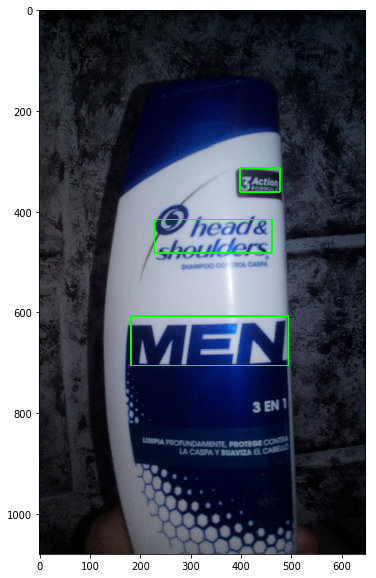

In [1]:
# USAGE
# python text_detection.py --image images/lebron_james.jpg --east frozen_east_text_detection.pb

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,
# 	help="path to input image")
# ap.add_argument("-east", "--east", type=str,
# 	help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
# 	help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,
# 	help="resized image width (should be multiple of 32)")
# ap.add_argument("-e", "--height", type=int, default=320,
# 	help="resized image height (should be multiple of 32)")
# args = vars(ap.parse_args())

# load the input image and grab the image dimensions
#image = cv2.imread(args["image"])
image = cv2.imread("img/Shampoo.jpg")
(H, W) = image.shape[:2]
scale=1
if(H > 1080 or W > 1920):
    scale = 1080/H
    if(1920/W < scale): scale = 1920/W
image = cv2.resize(image, (int(W*scale), int(H*scale)))

orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
# (newW, newH) = (args["width"], args["height"])
newW = newH = 320
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
#net = cv2.dnn.readNet(args["east"])
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
min_confidence = float(0.5)
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
# 		if scoresData[x] < args["min_confidence"]:
		if scoresData[x] < min_confidence:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
cv2.waitKey(0)